In [1]:
import numpy as np
from astropy.table import Table, join, Column
import matplotlib.pyplot as plt
from astropy import units as u
import sys
sys.path.append('../edge_pydb')
from edge_conv import *

## Depletion time vs stellar surface density for EDGE.  

In [2]:
hafile = '../img_califa/edge.pipe3d.hdf5'
cofile = '../img_comom/edge.comom_smo7.hdf5'

In [3]:
cotab=Table.read(cofile, path='smo')
hatab=Table.read(hafile, path='flux_elines_sm')
sttab=Table.read(hafile, path='SSP_sm')
join2 = join(cotab,hatab)
join3 = join(join2,sttab)
# For stellar surface density we need distance
globaldir = '../dat_glob/'
califa = Table.read(globaldir+'external/edge_califa.csv', format='ascii.ecsv')
dists = Table([califa['Name'], califa['caDistMpc']])
join4 = join(join3,dists,keys='Name')
print(join4.colnames)

['Name', 'ix', 'iy', 'ra_off', 'dec_off', 'emom0max', 'mom0', 'emom0', 'flux_[OII]3727', 'flux_[OIII]5007', 'flux_[OIII]4959', 'flux_Hbeta', 'flux_Halpha', 'flux_[NII]6583', 'flux_[NII]6548', 'flux_[SII]6717', 'flux_[SII]6731', 'vel_[OII]3727', 'vel_[OIII]5007', 'vel_[OIII]4959', 'vel_Hbeta', 'vel_Halpha', 'vel_[NII]6583', 'vel_[NII]6548', 'vel_[SII]6717', 'vel_[SII]6731', 'disp_[OII]3727', 'disp_[OIII]5007', 'disp_[OIII]4959', 'disp_Hbeta', 'disp_Halpha', 'disp_[NII]6583', 'disp_[NII]6548', 'disp_[SII]6717', 'disp_[SII]6731', 'EW_[OII]3727', 'EW_[OIII]5007', 'EW_[OIII]4959', 'EW_Hbeta', 'EW_Halpha', 'EW_[NII]6583', 'EW_[NII]6548', 'EW_[SII]6717', 'EW_[SII]6731', 'e_flux_[OII]3727', 'e_flux_[OIII]5007', 'e_flux_[OIII]4959', 'e_flux_Hbeta', 'e_flux_Halpha', 'e_flux_[NII]6583', 'e_flux_[NII]6548', 'e_flux_[SII]6717', 'e_flux_[SII]6731', 'e_vel_[OII]3727', 'e_vel_[OIII]5007', 'e_vel_[OIII]4959', 'e_vel_Hbeta', 'e_vel_Halpha', 'e_vel_[NII]6583', 'e_vel_[NII]6548', 'e_vel_[SII]6717', 'e_vel

In [4]:
# Separate the CO detections and non-detections
det = (join4['mom0']>3*join4['emom0']) & (join4['flux_Halpha']>3*join4['e_flux_Halpha'])
sig_mol = msd_co(join4['mom0'][det])
sig_sfr = sfr_ha(join4['flux_Halpha'][det],join4['flux_Hbeta'][det])
t_dep = sig_mol/sig_sfr
print('CO and Ha detections:',len(t_dep))

ndet = (join4['flux_Halpha']>3*join4['e_flux_Halpha']) & ~det
h2_ndet = msd_co(3*join4['emom0max'][ndet])
sf_ndet = sfr_ha(join4['flux_Halpha'][ndet],join4['flux_Hbeta'][ndet])
t_dep_ndet = h2_ndet/sf_ndet
print('CO non-detections, Ha detections:',len(t_dep_ndet))

CO and Ha detections: 4805
CO non-detections, Ha detections: 30638


/opt/conda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
../edge_pydb/edge_conv.py:12: RuntimeWarning: invalid value encountered in log10
  A_Ha = K_Ha/(-0.4*(K_Ha-K_Hb)) * np.log10((flux_ha/flux_hb)/2.86)
/opt/conda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [5]:
sig_star = stmass_pc2(np.array(join4['mass_ssp'][det]), 
                      dist=np.array(join4['caDistMpc'][det])*u.Mpc)
print(sig_star)
sig_star_ndet= stmass_pc2(np.array(join4['mass_ssp'][ndet]), 
                      dist=np.array(join4['caDistMpc'][ndet])*u.Mpc)

[   36.71501811    43.73673468    53.71304201 ...,   477.80203325
   716.97365124  1138.4641238 ] solMass / pc2


/opt/conda/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/conda/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'lw'
  s)


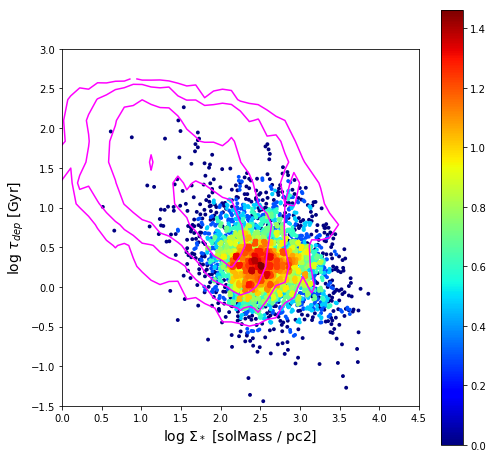

In [6]:
# Select data to plot (must be loggable)
not_nan = (~np.isnan(sig_star)) & (~np.isnan(t_dep)) & (sig_star>0) & (t_dep>0)
not_nan_ndet = (~np.isnan(sig_star_ndet)) & (~np.isnan(t_dep_ndet)) & (sig_star_ndet>0) & (t_dep_ndet>0)
x_det, y_det, z_det, *hist = xy2hist(sig_star[not_nan].value, t_dep[not_nan].value, log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sig_star_ndet[not_nan_ndet].value, 
                                         t_dep_ndet[not_nan_ndet].value, log=True, bins=[50,50])
# Make the scatter plots
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=15, edgecolor='', cmap=cm)
ax.contour(hist2[0].transpose(),[10,30,100,300],extent=[hist2[1].min(),hist2[1].max(),
    hist2[2].min(),hist2[2].max()],colors='magenta',lw=3)
plt.xlabel(r'log $\Sigma_*$ ['+str(sig_star.unit)+']',fontsize=14)
plt.ylabel(r'log $\tau_{dep}$ ['+str(t_dep.unit)+']',fontsize=14)
ax.set_aspect('equal')
ax.set_xlim(0,4.5)
ax.set_ylim(-1.5,3)
plt.colorbar(sc)